# Identifying Users With Similar Buying Habits and Preferences

## 1. Data Preprocessing

### Load data

In [2]:
import pandas as pd

aislesDF = pd.read_csv('../data/aisles.csv')
departmentDF = pd.read_csv('../data/departments.csv')
Order_Products_Prior_DF = pd.read_csv('../data/order_products_prior.csv')
Order_Products_Train_DF = pd.read_csv('../data/order_products_train.csv')
ordersDF = pd.read_csv('../data/orders.csv')
productsDF = pd.read_csv('../data/products.csv')


### Merge into one dataframe 

Only keep the users that exist in both 'prior' table and train eval set of 'orders' table.

In [3]:
# orders in prior merged with product names
Order_Product_Name_Prior = pd.merge(Order_Products_Prior_DF, 
                                    productsDF, how='left', on='product_id')
# Prior orders with user_id, product_id, product_name
Prior_User_Order_Product = pd.merge(Order_Product_Name_Prior, 
                                    ordersDF, how='left', on='order_id')

In [4]:
# keep only those that same user_id exists in both train and prior
Prior_User_Order_Product_inner = pd.merge(Prior_User_Order_Product,
                                          ordersDF[ordersDF['eval_set']=='train'][['user_id','eval_set']], 
                                          how='inner', on='user_id')

In [4]:
Prior_User_Order_Product_inner.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set_x,order_number,order_dow,order_hour_of_day,days_since_prior_order,eval_set_y
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,train
1,2,28985,2,1,Michigan Organic Kale,83,4,202279,prior,3,5,9,8.0,train
2,2,9327,3,0,Garlic Powder,104,13,202279,prior,3,5,9,8.0,train
3,2,45918,4,1,Coconut Butter,19,13,202279,prior,3,5,9,8.0,train
4,2,30035,5,0,Natural Sweetener,17,13,202279,prior,3,5,9,8.0,train


## 2. Feature Extraction

The features that will be extracted directly are:
* Mean of order_dow (order placed day of week)
* Mean of order_hour_of_day
* Mean of days_since_prior_order
* Total number of orders made
* Total number of products bought

Then we need another vectorized feature of product name: combine all the products name into one row per user, for word2vec analysis.

In [5]:
user_habit = Prior_User_Order_Product_inner[['user_id','order_id',
                                       'product_name','order_dow',
                                       'order_hour_of_day','days_since_prior_order']]

In [6]:
import numpy as np
# Create a dataframe: average value of each user
user_avg = user_habit.groupby('user_id')['order_dow',
                                'order_hour_of_day',
                                'days_since_prior_order'].agg(np.nanmean)
# Total number of orders of each user
user_order = user_habit.groupby('user_id').order_id.nunique()
user_avg['num_of_orders'] = user_order
# Total number of products of each user
product_number = user_habit.groupby('user_id')['order_id'].agg('count')
user_avg['num_of_products'] = product_number

In [7]:
# add product name to each user
name_list = []
for p_name in user_habit.groupby('user_id')['product_name']:
        name_list.append(' '.join(p_name[1]))

# add the names to dataframe
user_avg['product_name'] = name_list       

In [8]:
# Take a glimpse of the dataset
user_avg.head()

#Prior_User_Order_Product_inner.to_csv("../output/Prior_User_Order_Product_inner.csv")
#user_avg.to_csv('../output/user_avg.csv')

,order_dow,order_hour_of_day,days_since_prior_order,num_of_orders,num_of_products,product_name
user_id,,,,,,
1,2.644068,10.542373,20.259259,10,59,Soda Original Beef Jerky Pistachios Organic St...
2,2.005128,10.441026,15.967033,14,195,Artichoke Spinach Dip Chipotle Beef & Pork Rea...
5,1.621622,15.729730,14.500000,4,37,Uncured Genoa Salami Plain Whole Milk Yogurt W...
7,1.728155,13.631068,13.546392,20,206,85% Lean Ground Beef Organic Apple Slices Appl...
8,4.204082,2.448980,30.000000,3,49,Organic Baby Spinach Michigan Organic Kale Bag...


### Extract Vectorized Text Feature: Use PySpark Word2Vec

In [9]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Word2Vec

spark = SparkSession.builder.appName("User Habit").getOrCreate()

# load data
# user_avg = pd.read_csv("../output/user_avg.csv")
product_name_DF = pd.DataFrame(user_avg['product_name'])
# product_documentDF = spark.createDataFrame(product_name_DF)

In [11]:
product_name_DF.head()

,product_name
user_id,
1,Soda Original Beef Jerky Pistachios Organic St...
2,Artichoke Spinach Dip Chipotle Beef & Pork Rea...
5,Uncured Genoa Salami Plain Whole Milk Yogurt W...
7,85% Lean Ground Beef Organic Apple Slices Appl...
8,Organic Baby Spinach Michigan Organic Kale Bag...


In [12]:
# Sample a fraction of data due to large computation
sample_frac = 0.2
product_name_DF_sample  = product_name_DF.sample(frac = sample_frac, random_state=321)
sample_user_id  = product_name_DF_sample.index
print(sample_user_id)

Int64Index([160334,  88565,  79012, 169304,  55886, 116927,  97679,   7855,
            135591,  29129,
            ...
            202726,  56964,  66861, 132464, 114757,  17789, 192164,  82482,
            103592,  47895],
           dtype='int64', name='user_id', length=26242)


In [13]:
dataFrameList = []
for row in product_name_DF_sample['product_name']:
    tup = (row.split(' '),)
    dataFrameList.append(tup)

# Check by the length of output
print(len(dataFrameList))

26242


In [14]:
# Input data of word2vec: Each row is a bag of words from a sentence or document.
N = len(dataFrameList)//100
mod = len(dataFrameList) % 100
documentDF = spark.createDataFrame(dataFrameList[0:100], ["product_name"])

for i in range(1,N):
    documentDF_sub = spark.createDataFrame(dataFrameList[100*i:100*(i+1)], ["product_name"])
    documentDF = documentDF.union(documentDF_sub)
    
documentDF_sub = spark.createDataFrame(dataFrameList[100*N:len(dataFrameList)], ["product_name"])
documentDF = documentDF.union(documentDF_sub)

In [15]:
# Learn a mapping from words to Vectors.
word2Vec = Word2Vec(vectorSize=5, minCount=0, inputCol="product_name", outputCol="result")
model = word2Vec.fit(documentDF)

result = model.transform(documentDF)

In [18]:
# Vectors: densevector
vectorized_features = [ ]
for row in result.collect():
    text, vector = row
    vectorized_features.append(vector)

In [25]:
# Get values from densevector into array
vectorized_features_array=[]
for vectors in vectorized_features:
    vectorized_features_array.append(vectors.values)

In [39]:
# Names of vectorized feature columns
col_names = []
for i in range(1,6):
    name = "vectorized_feature_" + str(i)
    col_names.append(name)
    
# A dataframe: each vectorized feature as one column
vectorized_features_DF = pd.DataFrame(np.array(vectorized_features_array).reshape(len(dataFrameList),5), 
                 columns = col_names)

# Add "user_id" column
vectorized_features_DF['user_id'] = sample_user_id

In [50]:
# Take a glimpse
vectorized_features_DF.head()

,vectorized_feature_1,vectorized_feature_2,vectorized_feature_3,vectorized_feature_4,vectorized_feature_5,user_id
0,-0.282369,-0.182000,0.306287,0.100679,-0.120577,160334
1,0.281474,0.120445,0.273489,-0.253893,-0.660901,88565
2,-0.123565,-0.070204,0.214689,-0.303687,-0.310858,79012
3,-0.218316,-0.182006,0.067302,-0.076648,-0.175688,169304
4,-0.389383,-0.138049,0.040070,-0.079571,-0.091004,55886


### Combine All Features: Concatenate word2vec feature with other features into one dataframe

In [63]:
# slice user_avg with sampled user_id
user_avg_sampled = user_avg[user_avg.index.isin(sample_user_id)]
# set index as one column 'user_id'
user_avg_sampled.reset_index(level=0, inplace=True)
# merge two dfs on 'user_id'
user_habit_features = pd.merge(user_avg_sampled, vectorized_features_DF, how='inner', on="user_id")
# drop "product_name"
user_habit_features.drop('product_name', axis=1, inplace=True)

In [64]:
# Take a glimpse
user_habit_features.head()

,user_id,order_dow,order_hour_of_day,days_since_prior_order,num_of_orders,num_of_products,vectorized_feature_1,vectorized_feature_2,vectorized_feature_3,vectorized_feature_4,vectorized_feature_5
0,37,3.260638,14.250000,12.687500,23,188,-0.301768,-0.067088,0.302247,0.112837,-0.129281
1,43,2.346939,15.040816,10.549296,11,147,-0.184910,0.093092,0.036534,-0.195309,-0.231066
2,49,2.617021,13.617021,28.522727,8,47,-0.234430,-0.073425,0.100409,-0.179090,-0.092016
3,62,2.850000,13.275000,15.772152,10,80,-0.321395,-0.093903,0.118370,0.169000,-0.197463
4,64,3.888889,15.903704,10.966102,10,135,-0.258294,-0.100414,0.160984,0.075478,-0.148819


In [83]:
#user_habit_features.to_csv('../output/user_habit_features.txt', sep='\t', index=False)
#user_habit_features.to_csv('../output/user_habit_features.csv', sep='\t', index=False)
#user_habit_features_only = user_habit_features.loc[:, 'order_dow':]
#user_habit_features_only.to_csv('../output/user_habit_features_only.txt', sep='\t', index=False)
#user_habit_features_only.to_csv('../output/user_habit_features_only.csv', index=False)

## 3. Cluster Users: PySpark K-Means 

#### PCA: Reduce features to 2-dimensional

In [97]:
from sklearn.decomposition import PCA
user_habit_features_only = pd.read_csv('../output/user_habit_features_only.csv')
user_habit_features = pd.read_csv('../output/user_habit_features.csv', sep = '\t')
pca = PCA(n_components=2).fit(user_habit_features_only)
pca_2d = pca.transform(user_habit_features_only)

In [98]:
pca_df = pd.DataFrame(pca_2d)
#pca_df.to_csv('../output/pca_feature_df.txt', sep='\t', index=False)
#pca_df.to_csv('../output/pca_feature_df.csv', index=False)
pca_df['user_id'] = user_habit_features['user_id']
#pca_df.to_csv('../output/pca_df.txt', sep='\t', index=False)
#pca_df.to_csv('../output/pca_df.csv', index=False)

#### Find the optimal K

Find the optimal number of clusters by calculating the within set sum of squared error (WSSSE). As the number of cluster increases, WSSSE will decrease. The best choice is at the elbow of WSSSE graph.

In [99]:
# Load and parse the data
data_pca = sc.textFile("../output/pca_feature_df.txt")
parsedData_pca = data_pca.map(lambda line: array([float(x) for x in line.split('\t')]))

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

In [100]:
WSSSE_list_pca = []

K_range = range(5,185,5)
for K in K_range:
    
    # Build the model (cluster the data)
    clusters = KMeans.train(parsedData_pca, K, maxIterations=10, initializationMode="random")
    
    WSSSE_pca = parsedData_pca.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    print("====== k:"+str(K)+" -- Within Set Sum of Squared Error = " + str(WSSSE_pca) + "=======")
    WSSSE_list_pca.append(WSSSE_pca)

====== k:5 -- Within Set Sum of Squared Error = 925645.5695087881=======
====== k:10 -- Within Set Sum of Squared Error = 571873.9200253651=======
====== k:15 -- Within Set Sum of Squared Error = 404232.8312967894=======
====== k:20 -- Within Set Sum of Squared Error = 420393.85970603756=======
====== k:25 -- Within Set Sum of Squared Error = 528154.8771568451=======
====== k:30 -- Within Set Sum of Squared Error = 329658.82038827357=======
====== k:35 -- Within Set Sum of Squared Error = 305537.31041853153=======
====== k:40 -- Within Set Sum of Squared Error = 290879.92673649045=======
====== k:45 -- Within Set Sum of Squared Error = 301790.2795253965=======
====== k:50 -- Within Set Sum of Squared Error = 248299.86312096464=======
====== k:55 -- Within Set Sum of Squared Error = 227716.86435129843=======
====== k:60 -- Within Set Sum of Squared Error = 288854.47049812716=======
====== k:65 -- Within Set Sum of Squared Error = 269758.6048300275=======
====== k:70 -- Within Set Sum of

In [101]:
WSSSE_data_pca = {'K':K_range, "WSSSE": WSSSE_list_pca}
WSSSE_pca_DF = pd.DataFrame(WSSSE_data_pca)

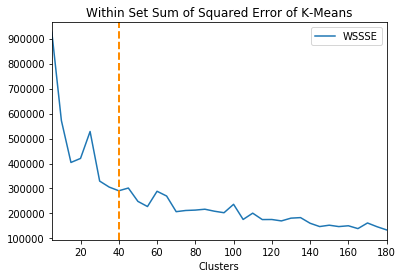

In [212]:
import matplotlib.pyplot as plt
fig = plt.figure()
WSSSE_pca_DF.plot(x='K', y='WSSSE')
plt.axvline(40, 
            color='darkorange', linestyle='dashed', linewidth=2)
plt.xlabel('Clusters')
plt.title('Within Set Sum of Squared Error of K-Means')
plt.show()
#fig.set_dpi(200)
#fig.savefig("../figs/WSSSE_pca.png")

The optimal k is usually one where there is an “elbow” in the WSSSE graph. So choose k = 40.

#### Run K-Means model with optimal K=40

In [104]:
K_opt = 40
clusters = KMeans.train(parsedData_pca, K_opt, maxIterations=10, initializationMode="random")
#clusters.save(sc, "../output/KMeansModel_pca")
#clusters = KMeansModel.load(sc, "../output/KMeansModel_pca")

#### Get the cluster labels

In [105]:
predicted_clusters = clusters.predict(parsedData_pca)
# Into a list
cluster_results = [ ]
for row in predicted_clusters.collect():
    cluster_results.append(row)

#### Get the centers for each user

In [158]:
def GetCenter(point):
    center = clusters.centers[clusters.predict(point)]
    return center

centerRDD = parsedData_pca.map(lambda point: GetCenter(point))

center_results = [ ]
for row in centerRDD.collect():
    center_results.append(row)
    
center_results = pd.DataFrame(center_results,columns=['x','y'])

#### KMeans Results Summary

In [193]:
kmeans_summary = center_results
kmeans_summary['clusters'] = cluster_results
kmeans_summary['user_id'] = user_habit_features['user_id']

kmeans_summary = pd.merge(pca_df, kmeans_summary ,how='inner', on='user_id')
#kmeans_summary.to_csv("../output/kmeans_summary.csv", header=True)

# x & y are coordinates of cluster centers
# 0 & 1 are coordinates of each user
kmeans_summary.head()

,0,1,user_id,x,y,clusters
0,30.851829,-5.844094,37,18.937511,1.034768,27
1,-10.814946,1.914740,43,-6.878718,-1.092668,10
2,-111.061957,4.096512,49,-114.330476,5.734811,19
3,-77.806557,0.083436,62,-77.620445,-4.536559,5
4,-22.860360,2.186689,64,-29.714480,-1.264748,8


#### Visualization of Kmeans Results

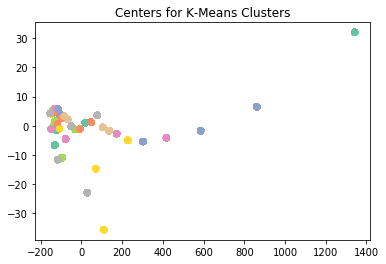

In [201]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure()

# Unique category labels for clusters
color_labels = kmeans_summary['clusters'].unique()

# List of RGB triplets
rgb_values = sns.color_palette("Set2", 40)

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

# Finally use the mapped values
plt.scatter(kmeans_summary['x'], kmeans_summary['y'], c=kmeans_summary['clusters'].map(color_map))
plt.title("Centers for K-Means Clusters")
plt.show()

#fig.set_dpi(200)
#fig.savefig('../figs/cluster_centers.png')

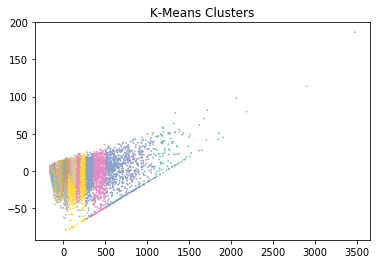

In [266]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure()

# Unique category labels for clusters
color_labels = kmeans_summary['clusters'].unique()

# List of RGB triplets
rgb_values = sns.color_palette("Set2", 40)

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))


# Finally use the mapped values
plt.scatter(kmeans_summary[0], kmeans_summary[1], c=kmeans_summary['clusters'].map(color_map), s = 0.5)
plt.title("K-Means Clusters")
plt.show()

#fig.set_dpi(300)
#fig.savefig('../figs/clusters.png')

#### Most Popular Products in Each User Cluster

In [276]:
import pandas as pd
kmeans_summary = pd.read_csv("../output/kmeans_summary.csv")

# merge to get clusters corresponds to product_name
cluster_order_info = pd.merge(kmeans_summary, Prior_User_Order_Product_inner, how='left', on='user_id')
cluster_product = cluster_order_info[['user_id','clusters','product_name']]

In [355]:
# count the frequency of products in each cluster
cluster_count = cluster_product.groupby(['clusters','product_name']).agg('count')
# reset indexes (twice)
# cluster_count.reset_index(level=0, inplace=True)
# cluster_count.reset_index(level=0, inplace=True)
# cluster_count.sort_values(['clusters','user_id'], ascending=False).groupby('clusters').head(5)

# Top 10 products in each cluster
top_products = cluster_count['user_id'].groupby(level=0, group_keys=False).nlargest(10).reset_index()

In [356]:
import matplotlib.pyplot as plt
#top_products.columns.values[2]='count'
top_products[top_products['clusters'] == 0][['product_name','user_id']]

,product_name,user_id
0,Bag of Organic Bananas,183
1,Banana,97
2,Raspberries,84
3,Strawberries,81
4,Organic Baby Spinach,73
5,Organic Strawberries,69
6,Soda,67
7,Spring Water,64
8,Hass Avocados,59
9,Clementines,52


In [357]:
wide_top_products =top_products.pivot(index='clusters', columns='product_name', values='user_id').fillna(0)
wide_top_products_percent = wide_top_products.div(wide_top_products.sum(axis=0), axis=1)
long_top_products = wide_top_products_percent.unstack().reset_index()
long_top_products.columns.values[2]='count'

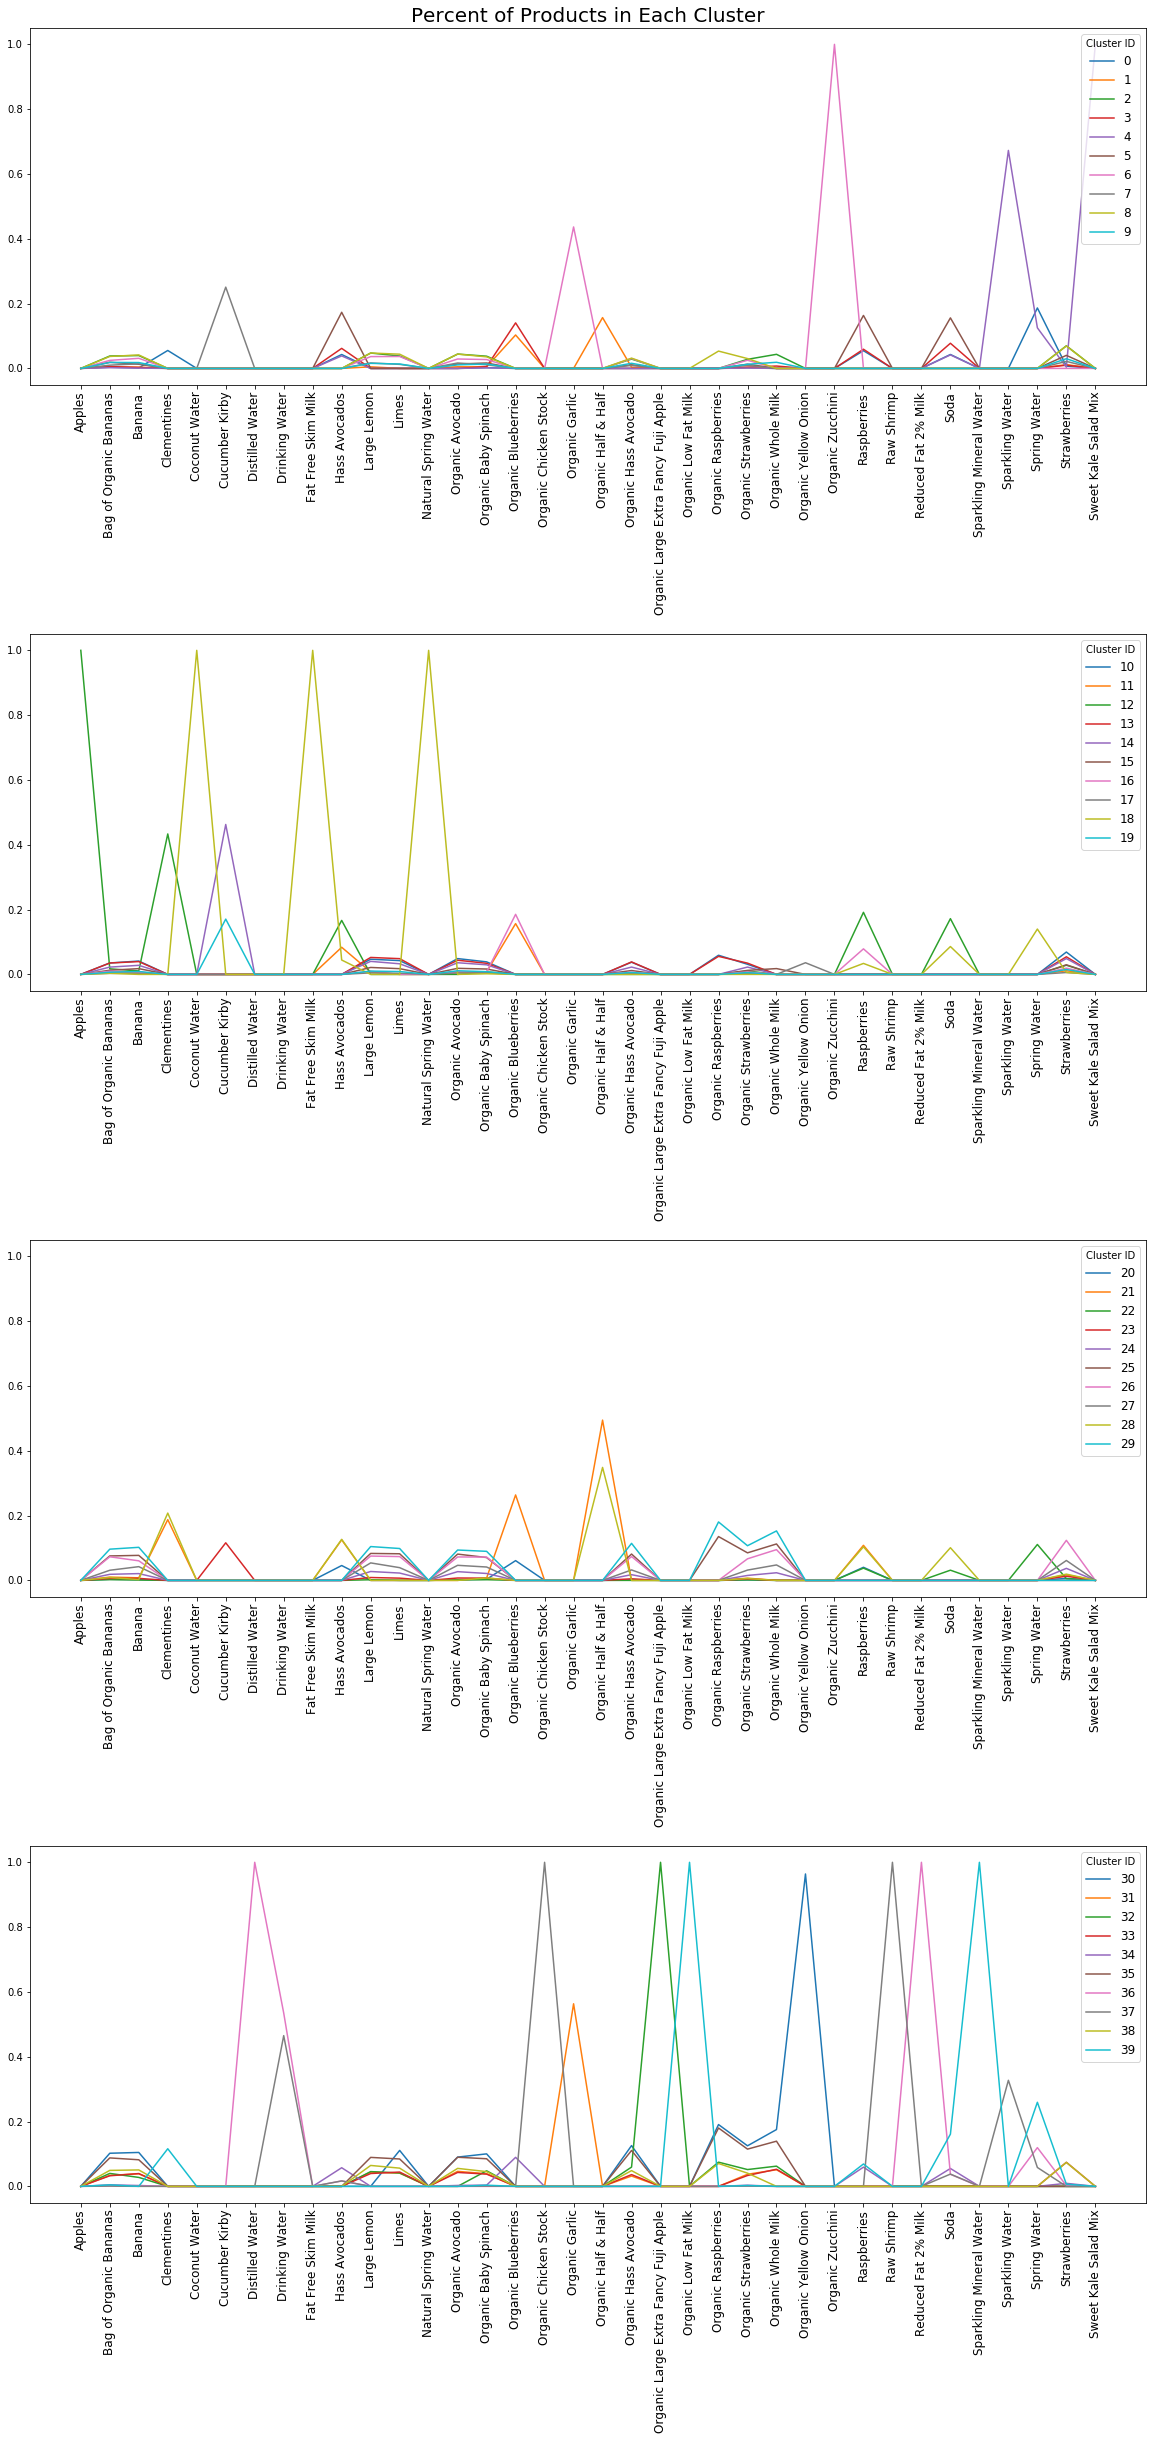

In [472]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,figsize=(20,40),sharey=True)
#plt.figure(figsize=(25,10))
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)
#ax.patch.set_visible(False)
#ax.grid(False)

group1 = []
for i in range(10):
    group1.append(i)
ax1.plot(wide_top_products_percent.loc[group1].transpose())
ax1.legend(wide_top_products_percent.transpose().columns[0:10],title="Cluster ID",loc='upper right',prop={'size': 12})
ax1.set_title('Percent of Products in Each Cluster',size=20)
#ax1.set_xticklabels(rotation=90, size=12)

group2 = []
for i in range(10,20):
    group2.append(i)
ax2.plot(wide_top_products_percent.loc[group2].transpose())
ax2.legend(wide_top_products_percent.transpose().columns[10:20], title="Cluster ID",loc='upper right',prop={'size': 12})
#ax2.set_xticklabels(rotation=90, size=12)

group3 = []
for i in range(20,30):
    group3.append(i)
ax3.plot(wide_top_products_percent.loc[group3].transpose())
ax3.legend(wide_top_products_percent.transpose().columns[20:30],title="Cluster ID",loc='upper right',prop={'size': 12})
#ax3.set_xticklabels(rotation=90, size=12)

group4 = []
for i in range(30,40):
    group4.append(i)
ax4.plot(wide_top_products_percent.loc[group4].transpose())
ax4.legend(wide_top_products_percent.transpose().columns[30:40],title="Cluster ID",loc='upper right',prop={'size': 12})
#ax4.set_xticklabels(rotation=90, size=12)
#plt.xticks(rotation=90, size=12)

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90, size=12)
    
plt.subplots_adjust(wspace=0, hspace=0.7)
#fig.tight_layout()

plt.show()
fig.set_dpi(300)
fig.savefig('../figs/cluster_product_frequency.png')